# Задание 6: Рекуррентные нейронные сети (RNNs)

Это задание адаптиповано из Deep NLP Course at ABBYY (https://github.com/DanAnastasyev/DeepNLP-Course) с разрешения автора - Даниила Анастасьева. Спасибо ему огромное!

In [ ]:
# !pip3 -qq install torch==0.4.1
# !pip3 -qq install bokeh==0.13.0
# !pip3 -qq install gensim==3.6.0
# !pip3 -qq install nltk
# !pip3 -qq install scikit-learn==0.20.2

In [ ]:
pip list

In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


if torch.cuda.is_available():
    from torch.cuda import FloatTensor, LongTensor
else:
    from torch import FloatTensor, LongTensor

np.random.seed(42)

# Рекуррентные нейронные сети (RNNs)

## POS Tagging

Мы рассмотрим применение рекуррентных сетей к задаче sequence labeling (последняя картинка).

![RNN types](http://karpathy.github.io/assets/rnn/diags.jpeg)

*From [The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)*

Самые популярные примеры для такой постановки задачи - Part-of-Speech Tagging и Named Entity Recognition.

Мы порешаем сейчас POS Tagging для английского.

Будем работать с таким набором тегов:
- ADJ - adjective (new, good, high, ...)
- ADP - adposition (on, of, at, ...)
- ADV - adverb (really, already, still, ...)
- CONJ - conjunction (and, or, but, ...)
- DET - determiner, article (the, a, some, ...)
- NOUN - noun (year, home, costs, ...)
- NUM - numeral (twenty-four, fourth, 1991, ...)
- PRT - particle (at, on, out, ...)
- PRON - pronoun (he, their, her, ...)
- VERB - verb (is, say, told, ...)
- . - punctuation marks (. , ;)
- X - other (ersatz, esprit, dunno, ...)

Скачаем данные:

In [2]:
import nltk
from sklearn.model_selection import train_test_split
from nltk.corpus import brown
nltk.download('brown')
nltk.download('universal_tagset')

data = nltk.corpus.brown.tagged_sents(tagset='universal')

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.


Пример размеченного предложения:

In [3]:
for word, tag in data[0]:
    print('{:19}\t{}'.format(word, tag))

The                	DET
Fulton             	NOUN
County             	NOUN
Grand              	ADJ
Jury               	NOUN
said               	VERB
Friday             	NOUN
an                 	DET
investigation      	NOUN
of                 	ADP
Atlanta's          	NOUN
recent             	ADJ
primary            	NOUN
election           	NOUN
produced           	VERB
``                 	.
no                 	DET
evidence           	NOUN
''                 	.
that               	ADP
any                	DET
irregularities     	NOUN
took               	VERB
place              	NOUN
.                  	.


Построим разбиение на train/val/test - наконец-то, всё как у нормальных людей.

На train будем учиться, по val - подбирать параметры и делать всякие early stopping, а на test - принимать модель по ее финальному качеству.

In [4]:
train_data, test_data = train_test_split(data, test_size=0.25, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.15, random_state=42)

print('Words count in train set:', sum(len(sent) for sent in train_data))
print('Words count in val set:', sum(len(sent) for sent in val_data))
print('Words count in test set:', sum(len(sent) for sent in test_data))

Words count in train set: 739769
Words count in val set: 130954
Words count in test set: 290469


Построим маппинги из слов в индекс и из тега в индекс:


In [5]:
words = {word for sample in train_data for word, tag in sample}
word2ind = {word: ind + 1 for ind, word in enumerate(words)}
word2ind['<pad>'] = 0

tags = {tag for sample in train_data for word, tag in sample}
tag2ind = {tag: ind + 1 for ind, tag in enumerate(tags)}
tag2ind['<pad>'] = 0

print('Unique words in train = {}. Tags = {}'.format(len(word2ind), tags))

Unique words in train = 45441. Tags = {'VERB', '.', 'DET', 'PRON', 'ADV', 'NUM', 'NOUN', 'CONJ', 'ADJ', 'PRT', 'X', 'ADP'}


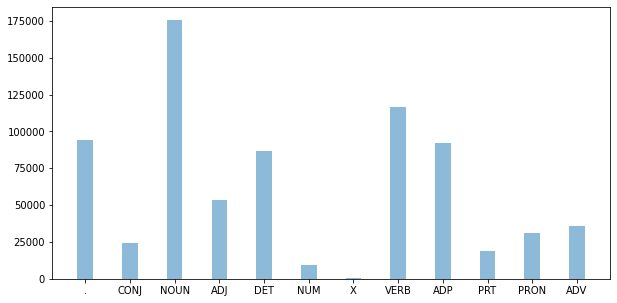

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

from collections import Counter

tag_distribution = Counter(tag for sample in train_data for _, tag in sample)
tag_distribution = [tag_distribution[tag] for tag in tags]

plt.figure(figsize=(10, 5))

bar_width = 0.35
plt.bar(np.arange(len(tags)), tag_distribution, bar_width, align='center', alpha=0.5)
plt.xticks(np.arange(len(tags)), tags)
    
plt.show()

## Бейзлайн

Какой самый простой теггер можно придумать? Давайте просто запоминать, какие теги самые вероятные для слова (или для последовательности):

![tag-context](https://www.nltk.org/images/tag-context.png)  
*From [Categorizing and Tagging Words, nltk](https://www.nltk.org/book/ch05.html)*

На картинке показано, что для предсказания $t_n$ используются два предыдущих предсказанных тега + текущее слово. По корпусу считаются вероятность для $P(t_n| w_n, t_{n-1}, t_{n-2})$, выбирается тег с максимальной вероятностью.

Более аккуратно такая идея реализована в Hidden Markov Models: по тренировочному корпусу вычисляются вероятности $P(w_n| t_n), P(t_n|t_{n-1}, t_{n-2})$ и максимизируется их произведение.

Простейший вариант - униграммная модель, учитывающая только слово:

In [ ]:
import nltk

default_tagger = nltk.DefaultTagger('NN')

unigram_tagger = nltk.UnigramTagger(train_data, backoff=default_tagger)
print('Accuracy of unigram tagger = {:.2%}'.format(unigram_tagger.evaluate(test_data)))

Accuracy of unigram tagger = 92.62%


Добавим вероятности переходов:

In [ ]:
bigram_tagger = nltk.BigramTagger(train_data, backoff=unigram_tagger)
print('Accuracy of bigram tagger = {:.2%}'.format(bigram_tagger.evaluate(test_data)))

Accuracy of bigram tagger = 93.42%


Обратите внимание, что `backoff` важен:

In [ ]:
trigram_tagger = nltk.TrigramTagger(train_data)
print('Accuracy of trigram tagger = {:.2%}'.format(trigram_tagger.evaluate(test_data)))

Accuracy of trigram tagger = 23.33%


## Увеличиваем контекст с рекуррентными сетями

Униграмная модель работает на удивление хорошо, но мы же собрались учить сеточки.

Омонимия - основная причина, почему униграмная модель плоха:  
*“he cashed a check at the **bank**”*  
vs  
*“he sat on the **bank** of the river”*

Поэтому нам очень полезно учитывать контекст при предсказании тега.

Воспользуемся LSTM - он умеет работать с контекстом очень даже хорошо:

![](https://image.ibb.co/kgmoff/Baseline-Tagger.png)

Синим показано выделение фичей из слова, LSTM оранжевенький - он строит эмбеддинги слов с учетом контекста, а дальше зелененькая логистическая регрессия делает предсказания тегов.

In [6]:
def convert_data(data, word2ind, tag2ind):
    X = [[word2ind.get(word, 0) for word, _ in sample] for sample in data]
    y = [[tag2ind[tag] for _, tag in sample] for sample in data]
    
    return X, y

X_train, y_train = convert_data(train_data, word2ind, tag2ind)
X_val, y_val = convert_data(val_data, word2ind, tag2ind)
X_test, y_test = convert_data(test_data, word2ind, tag2ind)

In [7]:
def iterate_batches(data, batch_size):
    X, y = data
    n_samples = len(X)

    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_indices = indices[start:end]
        
        max_sent_len = max(len(X[ind]) for ind in batch_indices)
        X_batch = np.zeros((max_sent_len, len(batch_indices)))
        y_batch = np.zeros((max_sent_len, len(batch_indices)))
        
        for batch_ind, sample_ind in enumerate(batch_indices):
            X_batch[:len(X[sample_ind]), batch_ind] = X[sample_ind]
            y_batch[:len(y[sample_ind]), batch_ind] = y[sample_ind]
            
        yield X_batch, y_batch

In [8]:
X_batch, y_batch = next(iterate_batches((X_train, y_train), 4))

X_batch, X_batch.shape

(array([[33128., 30150., 12962.,  2789.],
        [16505., 34549., 38028.,  2962.],
        [22547., 32667., 35535.,  3389.],
        [ 2789., 21050., 42233.,  7343.],
        [31356.,  4208., 22547., 32667.],
        [32667., 24917., 24743., 16830.],
        [ 2789., 31660., 32667., 42978.],
        [19746., 35301.,  5816., 34869.],
        [44908., 26337., 12252.,  9996.],
        [31270.,  2789.,  2789., 12680.],
        [32667., 43499., 14875., 32667.],
        [  323.,  4855., 11693.,  9996.],
        [43260., 32667.,  2789., 11900.],
        [39195., 16172., 42436., 27675.],
        [    0., 27300., 32802., 39438.],
        [    0., 16143., 32667., 10075.],
        [    0., 17611.,  2789., 38028.],
        [    0., 11693.,  5034.,  7705.],
        [    0.,  2789., 11693., 27761.],
        [    0., 34160., 28411., 13786.],
        [    0., 11693., 32750., 22547.],
        [    0., 42253., 18484., 38221.],
        [    0., 39195., 25810., 39195.],
        [    0.,     0., 31622.,  

**Задание** Реализуйте `LSTMTagger`:

In [9]:
class LSTMTagger(nn.Module):
    def __init__(self, vocab_size, tagset_size, word_emb_dim=100, lstm_hidden_dim=128, lstm_layers_count=1):
        super().__init__()
        self.hidden_dim = lstm_hidden_dim
        self.word_embeddings = nn.Embedding(vocab_size, word_emb_dim)
        self.lstm = nn.LSTM(word_emb_dim, lstm_hidden_dim, lstm_layers_count)
        self.hidden2tag = nn.Linear(lstm_hidden_dim, tagset_size)
        

    def forward(self, inputs):
        embeds = self.word_embeddings(inputs)
        lstm_out, _ = self.lstm(embeds)
        tag_space = self.hidden2tag(lstm_out)
        return tag_space

**Задание** Научитесь считать accuracy и loss (а заодно проверьте, что модель работает)

In [11]:
model = LSTMTagger(
    vocab_size=len(word2ind),
    tagset_size=len(tag2ind)
)

X_batch, y_batch = torch.LongTensor(X_batch), torch.LongTensor(y_batch)

tag_space = model(X_batch)
tag_space_resh = tag_space.view(-1, tag_space.shape[-1])
y_batch_resh = y_batch.view(-1) 
criterion = nn.CrossEntropyLoss(ignore_index=0)
loss = criterion(tag_space_resh, y_batch_resh)
print(loss.item())
mask = (y_batch != 0).type('torch.LongTensor')
y_pred = torch.argmax(tag_space, 2)
cur_correct_count, cur_sum_count = torch.sum(mask*torch.eq(y_batch, y_pred)).item(), torch.sum(mask).item()
accuracy = cur_correct_count*100/cur_sum_count
print(accuracy)



2.5731093883514404
3.260869565217391


**Задание** Вставьте эти вычисление в функцию:

In [18]:
import math
from tqdm import tqdm


def do_epoch(model, criterion, data, batch_size, optimizer=None, name=None):
    epoch_loss = 0
    correct_count = 0
    sum_count = 0
    
    is_train = not optimizer is None
    name = name or ''
    model.train(is_train)
    
    batches_count = math.ceil(len(data[0]) / batch_size)
    
    with torch.autograd.set_grad_enabled(is_train):
        with tqdm(total=batches_count) as progress_bar:
            for i, (X_batch, y_batch) in enumerate(iterate_batches(data, batch_size)):
                X_batch, y_batch = LongTensor(X_batch), LongTensor(y_batch)
                tag_space = model(X_batch)
                tag_space_resh = tag_space.view(-1, tag_space.shape[-1])
                y_batch_resh = y_batch.view(-1) 
                loss = criterion(tag_space_resh, y_batch_resh)
                if torch.cuda.is_available():
                  mask = (y_batch != 0).type('torch.LongTensor').cuda()
                else:
                  mask = (y_batch != 0).type('torch.LongTensor')

                epoch_loss += loss.item()

                if optimizer:
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                y_pred = torch.argmax(tag_space, 2)
                cur_correct_count, cur_sum_count = torch.sum(mask*torch.eq(y_batch, y_pred)).item(), torch.sum(mask).item() 

                correct_count += cur_correct_count
                sum_count += cur_sum_count

                progress_bar.update()
                progress_bar.set_description('{:>5s} Loss = {:.5f}, Accuracy = {:.2%}'.format(
                    name, loss.item(), cur_correct_count / cur_sum_count)
                )
                
            progress_bar.set_description('{:>5s} Loss = {:.5f}, Accuracy = {:.2%}'.format(
                name, epoch_loss / batches_count, correct_count / sum_count)
            )

    return epoch_loss / batches_count, correct_count / sum_count


def fit(model, criterion, optimizer, train_data, epochs_count=1, batch_size=32,
        val_data=None, val_batch_size=None):
        
    if not val_data is None and val_batch_size is None:
        val_batch_size = batch_size
        
    for epoch in range(epochs_count):
        name_prefix = '[{} / {}] '.format(epoch + 1, epochs_count)
        train_loss, train_acc = do_epoch(model, criterion, train_data, batch_size, optimizer, name_prefix + 'Train:')
        
        if not val_data is None:
            val_loss, val_acc = do_epoch(model, criterion, val_data, val_batch_size, None, name_prefix + '  Val:')

In [21]:
lr = 0.001

if torch.cuda.is_available():
    model = LSTMTagger(
    vocab_size=len(word2ind),
    tagset_size=len(tag2ind)
               ).cuda()
    criterion = nn.CrossEntropyLoss(ignore_index = 0).cuda()
    optimizer = optim.Adam(model.parameters(), lr = lr)
    fit(model, criterion, optimizer, train_data=(X_train, y_train), epochs_count=50,
    batch_size=64, val_data=(X_val, y_val), val_batch_size=512)
else:
    model = LSTMTagger(
    vocab_size=len(word2ind),
    tagset_size=len(tag2ind))
    criterion = nn.CrossEntropyLoss(ignore_index = 0)
    optimizer = optim.Adam(model.parameters(), lr = lr)
    fit(model, criterion, optimizer, train_data=(X_train, y_train), epochs_count=50, batch_size=64, val_data=(X_val, y_val), val_batch_size=512)


[1 / 50] Train: Loss = 0.69130, Accuracy = 78.21%: 100%|██████████| 572/572 [00:12<00:00, 44.42it/s]
[1 / 50]   Val: Loss = 0.35129, Accuracy = 88.09%: 100%|██████████| 13/13 [00:00<00:00, 38.83it/s]
[2 / 50] Train: Loss = 0.27213, Accuracy = 90.95%: 100%|██████████| 572/572 [00:11<00:00, 47.88it/s]
[2 / 50]   Val: Loss = 0.23126, Accuracy = 92.16%: 100%|██████████| 13/13 [00:00<00:00, 39.63it/s]
[3 / 50] Train: Loss = 0.18402, Accuracy = 93.90%: 100%|██████████| 572/572 [00:11<00:00, 49.44it/s]
[3 / 50]   Val: Loss = 0.18557, Accuracy = 93.72%: 100%|██████████| 13/13 [00:00<00:00, 38.72it/s]
[4 / 50] Train: Loss = 0.13764, Accuracy = 95.40%: 100%|██████████| 572/572 [00:11<00:00, 48.68it/s]
[4 / 50]   Val: Loss = 0.16333, Accuracy = 94.54%: 100%|██████████| 13/13 [00:00<00:00, 41.79it/s]
[5 / 50] Train: Loss = 0.10706, Accuracy = 96.40%: 100%|██████████| 572/572 [00:11<00:00, 48.82it/s]
[5 / 50]   Val: Loss = 0.15168, Accuracy = 94.93%: 100%|██████████| 13/13 [00:00<00:00, 40.61it/s]


KeyboardInterrupt: ignored

### Masking

**Задание** Проверьте себя - не считаете ли вы потери и accuracy на паддингах - очень легко получить высокое качество за счет этого.

У функции потерь есть параметр `ignore_index`, для таких целей. Для accuracy нужно использовать маскинг - умножение на маску из нулей и единиц, где нули на позициях паддингов (а потом усреднение по ненулевым позициям в маске).

**Задание** Посчитайте качество модели на тесте. Ожидается результат лучше бейзлайна!

In [22]:
loss_test, accuracy_test = do_epoch(model, criterion, data = (X_test, y_test), batch_size = 256, optimizer=None, name=None)


      Loss = 0.15708, Accuracy = 95.42%: 100%|██████████| 56/56 [00:01<00:00, 53.39it/s]


### Bidirectional LSTM

Благодаря BiLSTM можно использовать сразу оба контеста при предсказании тега слова. Т.е. для каждого токена $w_i$ forward LSTM будет выдавать представление $\mathbf{f_i} \sim (w_1, \ldots, w_i)$ - построенное по всему левому контексту - и $\mathbf{b_i} \sim (w_n, \ldots, w_i)$ - представление правого контекста. Их конкатенация автоматически захватит весь доступный контекст слова: $\mathbf{h_i} = [\mathbf{f_i}, \mathbf{b_i}] \sim (w_1, \ldots, w_n)$.

![BiLSTM](https://www.researchgate.net/profile/Wang_Ling/publication/280912217/figure/fig2/AS:391505383575555@1470353565299/Illustration-of-our-neural-network-for-POS-tagging.png)  
*From [Finding Function in Form: Compositional Character Models for Open Vocabulary Word Representation](https://arxiv.org/abs/1508.02096)*

**Задание** Добавьте Bidirectional LSTM.

In [23]:
class BidirectionalLSTMTagger(nn.Module):
    def __init__(self, vocab_size, tagset_size, word_emb_dim=100, lstm_hidden_dim=128, lstm_layers_count=1, bidirectional=True):
        super().__init__()
        self.hidden_dim = lstm_hidden_dim
        self.word_embeddings = nn.Embedding(vocab_size, word_emb_dim)
        self.lstm = nn.LSTM(word_emb_dim, lstm_hidden_dim, lstm_layers_count, bidirectional=True)
        self.hidden2tag = nn.Linear(lstm_hidden_dim * 2 if bidirectional else lstm_hidden_dim, tagset_size)
        

    def forward(self, inputs):
        embeds = self.word_embeddings(inputs)
        lstm_out, _ = self.lstm(embeds)
        tag_space = self.hidden2tag(lstm_out)
        return tag_space

In [24]:
lr = 0.001

if torch.cuda.is_available():
    model_2 = BidirectionalLSTMTagger(
    vocab_size=len(word2ind),
    tagset_size=len(tag2ind)
               ).cuda()
    criterion = nn.CrossEntropyLoss(ignore_index = 0).cuda()
    optimizer = optim.Adam(model_2.parameters(), lr = lr)
    fit(model_2, criterion, optimizer, train_data=(X_train, y_train), epochs_count=30,
    batch_size=64, val_data=(X_val, y_val), val_batch_size=512)
else:
    model_2 = BidirectionalLSTMTagger(
    vocab_size=len(word2ind),
    tagset_size=len(tag2ind))
    criterion = nn.CrossEntropyLoss(ignore_index = 0)
    optimizer = optim.Adam(model_2.parameters(), lr = lr)
    fit(model_2, criterion, optimizer, train_data=(X_train, y_train), epochs_count=30, batch_size=64, val_data=(X_val, y_val), val_batch_size=512)

[1 / 30] Train: Loss = 0.55251, Accuracy = 82.46%: 100%|██████████| 572/572 [00:13<00:00, 42.05it/s]
[1 / 30]   Val: Loss = 0.28211, Accuracy = 90.82%: 100%|██████████| 13/13 [00:00<00:00, 32.08it/s]
[2 / 30] Train: Loss = 0.20565, Accuracy = 93.49%: 100%|██████████| 572/572 [00:13<00:00, 41.75it/s]
[2 / 30]   Val: Loss = 0.19070, Accuracy = 93.92%: 100%|██████████| 13/13 [00:00<00:00, 32.31it/s]
[3 / 30] Train: Loss = 0.13036, Accuracy = 95.97%: 100%|██████████| 572/572 [00:13<00:00, 41.84it/s]
[3 / 30]   Val: Loss = 0.15772, Accuracy = 94.96%: 100%|██████████| 13/13 [00:00<00:00, 33.82it/s]
[4 / 30] Train: Loss = 0.08894, Accuracy = 97.31%: 100%|██████████| 572/572 [00:13<00:00, 41.91it/s]
[4 / 30]   Val: Loss = 0.13390, Accuracy = 95.76%: 100%|██████████| 13/13 [00:00<00:00, 30.66it/s]
[5 / 30] Train: Loss = 0.06190, Accuracy = 98.17%: 100%|██████████| 572/572 [00:13<00:00, 41.82it/s]
[5 / 30]   Val: Loss = 0.13220, Accuracy = 95.86%: 100%|██████████| 13/13 [00:00<00:00, 31.80it/s]


KeyboardInterrupt: ignored

In [25]:
loss_test, accuracy_test = do_epoch(model_2, criterion, data = (X_test, y_test), batch_size = 256, optimizer=None, name=None)

      Loss = 0.14781, Accuracy = 96.36%: 100%|██████████| 56/56 [00:01<00:00, 47.86it/s]


### Предобученные эмбеддинги

Мы знаем, какая клёвая вещь - предобученные эмбеддинги. При текущем размере обучающей выборки еще можно было учить их и с нуля - с меньшей было бы совсем плохо.

Поэтому стандартный пайплайн - скачать эмбеддинги, засунуть их в сеточку. Запустим его:

In [27]:
import gensim.downloader as api

w2v_model = api.load('glove-wiki-gigaword-100')

[==================================================] 100.0% 128.1/128.1MB downloaded


In [60]:
w2v_model.vectors.shape

(400000, 100)

Построим подматрицу для слов из нашей тренировочной выборки:

In [62]:
embeddings_random = nn.Embedding(len(word2ind), w2v_model.vectors.shape[1])
embeddings_random.weight[0]



tensor([-0.5829,  0.2339,  2.3784,  1.0894,  0.0451, -0.8623, -0.8749, -0.2668,
        -0.1006,  1.0918, -0.6821, -2.0795,  1.0524,  1.3103, -0.0489,  0.2822,
        -0.1044, -0.6328,  0.2186, -0.6651,  0.1027, -1.0303,  1.1721, -0.0701,
         0.8566,  0.0772, -0.5140, -0.3402,  1.1397,  2.1688,  1.6801, -0.4126,
         0.7643,  1.7734, -0.1070,  0.0032, -0.7419,  0.7482, -1.5416, -0.6400,
         0.8721,  0.3673,  0.5741,  0.6192,  0.5363, -1.4932,  1.8720, -0.2954,
         1.1492, -1.8724, -0.6700,  1.5069, -0.8986, -1.2814,  1.7993,  1.0852,
        -0.8850,  0.7317,  0.5117, -1.3841,  1.0353, -2.7538,  0.3128,  0.9846,
        -0.2471, -1.2489,  0.0670,  0.9404,  1.6305,  0.7104,  0.6247,  0.7898,
         1.0067,  0.4022,  0.8533,  0.1191,  0.7641, -0.0310,  0.4038,  1.7090,
        -0.9338,  0.5722,  1.3514, -0.6991, -0.2681,  0.1436,  1.1634, -0.6373,
         0.7604,  0.4045,  1.4203,  0.6764,  0.0945,  0.2908, -1.0721, -0.7583,
         0.9824, -0.4793,  0.0255, -0.21

In [63]:
known_count = 0
embeddings = embeddings_random.weight.detach().numpy()

for word, ind in word2ind.items():
    word = word.lower()
    if word in w2v_model.vocab:
        embeddings[ind] = w2v_model.get_vector(word)
        known_count += 1
        
print('Know {} out of {} word embeddings'.format(known_count, len(word2ind)))

Know 38736 out of 45441 word embeddings


In [64]:
embeddings[0]      

array([-0.5829399 ,  0.23387036,  2.3784485 ,  1.089427  ,  0.04513456,
       -0.8623267 , -0.87494856, -0.26681286, -0.10060922,  1.0917975 ,
       -0.682061  , -2.0794647 ,  1.0524249 ,  1.3103032 , -0.0488999 ,
        0.28220072, -0.10440145, -0.6327664 ,  0.21860212, -0.6651458 ,
        0.10267833, -1.030266  ,  1.172102  , -0.07012459,  0.85664773,
        0.07718737, -0.5140412 , -0.340233  ,  1.1397343 ,  2.1688163 ,
        1.6801164 , -0.41256994,  0.764268  ,  1.7734082 , -0.10702871,
        0.00318456, -0.7419305 ,  0.7481521 , -1.5416222 , -0.6400395 ,
        0.8720644 ,  0.36726382,  0.5741162 ,  0.6192402 ,  0.53634685,
       -1.4932137 ,  1.8720047 , -0.29536095,  1.1492256 , -1.8724427 ,
       -0.67004454,  1.5068835 , -0.8986388 , -1.2814192 ,  1.7992712 ,
        1.085196  , -0.88498145,  0.7317133 ,  0.51174945, -1.3841044 ,
        1.0352858 , -2.753825  ,  0.31276682,  0.98457664, -0.24713595,
       -1.2488681 ,  0.06696247,  0.9404115 ,  1.6305333 ,  0.71

**Задание** Сделайте модель с предобученной матрицей. Используйте `nn.Embedding.from_pretrained`.

In [68]:
class LSTMTaggerWithPretrainedEmbs(nn.Module):
    def __init__(self, embeddings, tagset_size, lstm_hidden_dim=128, lstm_layers_count=1):
        super().__init__()
        self.hidden_dim = lstm_hidden_dim
        self.word_embeddings = nn.Embedding.from_pretrained(torch.Tensor(embeddings))
        self.lstm = nn.LSTM(embeddings.shape[1], lstm_hidden_dim, lstm_layers_count)
        self.hidden2tag = nn.Linear(lstm_hidden_dim, tagset_size)

    def forward(self, inputs):
        embeds = self.word_embeddings(inputs)
        lstm_out, _ = self.lstm(embeds)
        tag_space = self.hidden2tag(lstm_out)
        return tag_space

In [69]:
if torch.cuda.is_available():
  model_3 = LSTMTaggerWithPretrainedEmbs(
      embeddings=embeddings,
      tagset_size=len(tag2ind)
  ).cuda()

  criterion = nn.CrossEntropyLoss(ignore_index=0)
  optimizer = optim.Adam(model_3.parameters())

  fit(model_3, criterion, optimizer, train_data=(X_train, y_train), epochs_count=100,
      batch_size=64, val_data=(X_val, y_val), val_batch_size=512)
else:
  model_3 = LSTMTaggerWithPretrainedEmbs(
      embeddings=embeddings,
      tagset_size=len(tag2ind)
  )

  criterion = nn.CrossEntropyLoss(ignore_index=0)
  optimizer = optim.Adam(model_3.parameters())

  fit(model_3, criterion, optimizer, train_data=(X_train, y_train), epochs_count=100,
      batch_size=64, val_data=(X_val, y_val), val_batch_size=512)

[1 / 100] Train: Loss = 0.63030, Accuracy = 81.25%: 100%|██████████| 572/572 [00:12<00:00, 46.65it/s]
[1 / 100]   Val: Loss = 0.32517, Accuracy = 89.84%: 100%|██████████| 13/13 [00:00<00:00, 32.08it/s]
[2 / 100] Train: Loss = 0.24741, Accuracy = 92.38%: 100%|██████████| 572/572 [00:11<00:00, 47.95it/s]
[2 / 100]   Val: Loss = 0.22727, Accuracy = 92.81%: 100%|██████████| 13/13 [00:00<00:00, 32.25it/s]
[3 / 100] Train: Loss = 0.18104, Accuracy = 94.29%: 100%|██████████| 572/572 [00:11<00:00, 50.38it/s]
[3 / 100]   Val: Loss = 0.19009, Accuracy = 94.00%: 100%|██████████| 13/13 [00:00<00:00, 33.17it/s]
[4 / 100] Train: Loss = 0.14973, Accuracy = 95.21%: 100%|██████████| 572/572 [00:11<00:00, 50.29it/s]
[4 / 100]   Val: Loss = 0.16937, Accuracy = 94.55%: 100%|██████████| 13/13 [00:00<00:00, 33.51it/s]
[5 / 100] Train: Loss = 0.13130, Accuracy = 95.76%: 100%|██████████| 572/572 [00:11<00:00, 51.68it/s]
[5 / 100]   Val: Loss = 0.15620, Accuracy = 95.02%: 100%|██████████| 13/13 [00:00<00:00, 3

KeyboardInterrupt: ignored

**Задание** Оцените качество модели на тестовой выборке. Обратите внимание, вовсе не обязательно ограничиваться векторами из урезанной матрицы - вполне могут найтись слова в тесте, которых не было в трейне и для которых есть эмбеддинги.

Добейтесь качества лучше прошлых моделей.

In [70]:
loss_test, accuracy_test = do_epoch(model_3, criterion, data = (X_test, y_test), batch_size = 256, optimizer=None, name=None)

      Loss = 0.16293, Accuracy = 95.58%: 100%|██████████| 56/56 [00:01<00:00, 53.15it/s]


In [76]:
class BidirectionalLSTMTaggerWithPretrainedEmbs(nn.Module):
    def __init__(self, embeddings, tagset_size, lstm_hidden_dim=128, lstm_layers_count=1):
        super().__init__()
        self.hidden_dim = lstm_hidden_dim
        self.word_embeddings = nn.Embedding.from_pretrained(torch.Tensor(embeddings))
        self.lstm = nn.LSTM(embeddings.shape[1], lstm_hidden_dim, lstm_layers_count, bidirectional=True)
        self.hidden2tag = nn.Linear(lstm_hidden_dim * 2, tagset_size)

    def forward(self, inputs):
        embeds = self.word_embeddings(inputs)
        lstm_out, _ = self.lstm(embeds)
        tag_space = self.hidden2tag(lstm_out)
        return tag_space

In [78]:
if torch.cuda.is_available():
  model_4 = BidirectionalLSTMTaggerWithPretrainedEmbs(
      embeddings=embeddings,
      tagset_size=len(tag2ind)
  ).cuda()

  criterion = nn.CrossEntropyLoss(ignore_index=0)
  optimizer = optim.Adam(model_4.parameters())

  fit(model_4, criterion, optimizer, train_data=(X_train, y_train), epochs_count=100,
      batch_size=64, val_data=(X_val, y_val), val_batch_size=512)
else:
  model_4 = BidirectionalLSTMTaggerWithPretrainedEmbs(
      embeddings=embeddings,
      tagset_size=len(tag2ind)
  )
  criterion = nn.CrossEntropyLoss(ignore_index=0)
  optimizer = optim.Adam(model_4.parameters())

  fit(model_4, criterion, optimizer, train_data=(X_train, y_train), epochs_count=11,
      batch_size=64, val_data=(X_val, y_val), val_batch_size=512)

[1 / 100] Train: Loss = 0.48143, Accuracy = 85.67%: 100%|██████████| 572/572 [00:11<00:00, 49.88it/s]
[1 / 100]   Val: Loss = 0.24107, Accuracy = 92.76%: 100%|██████████| 13/13 [00:00<00:00, 31.37it/s]
[2 / 100] Train: Loss = 0.17060, Accuracy = 94.93%: 100%|██████████| 572/572 [00:11<00:00, 50.87it/s]
[2 / 100]   Val: Loss = 0.16785, Accuracy = 94.86%: 100%|██████████| 13/13 [00:00<00:00, 32.45it/s]
[3 / 100] Train: Loss = 0.12019, Accuracy = 96.45%: 100%|██████████| 572/572 [00:11<00:00, 50.31it/s]
[3 / 100]   Val: Loss = 0.13495, Accuracy = 95.97%: 100%|██████████| 13/13 [00:00<00:00, 32.45it/s]
[4 / 100] Train: Loss = 0.09507, Accuracy = 97.15%: 100%|██████████| 572/572 [00:11<00:00, 50.03it/s]
[4 / 100]   Val: Loss = 0.12338, Accuracy = 96.33%: 100%|██████████| 13/13 [00:00<00:00, 32.36it/s]
[5 / 100] Train: Loss = 0.07946, Accuracy = 97.62%: 100%|██████████| 572/572 [00:11<00:00, 50.35it/s]
[5 / 100]   Val: Loss = 0.11329, Accuracy = 96.65%: 100%|██████████| 13/13 [00:00<00:00, 3

KeyboardInterrupt: ignored

In [79]:
loss_test, accuracy_test = do_epoch(model_4, criterion, data = (X_test, y_test), batch_size = 256, optimizer=None, name=None)

      Loss = 0.11790, Accuracy = 96.89%: 100%|██████████| 56/56 [00:01<00:00, 44.92it/s]
